## Artificial Neural Networks: Basic guide ##

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
import scipy as sp
import tensorflow as tf
import random as rn

import keras
from keras import backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras import metrics, regularizers, optimizers

from sklearn.metrics import *

import matplotlib.pyplot as plt
import matplotlib as mpl

/home/timokerre/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data generation ###

In [2]:
# Binary categorisation 1
def categorical1(N):
    """ data(samples, features)"""
    
    global seed
     
    data = np.empty(shape=(N,2))  
    tar = np.empty(shape=(N)) 
    N1 = int(N/2)

    # Positive samples
    data[:N1,:] = np.random.normal(loc=1, scale=0.5, size=(N1,2))
    # Negative samples 
    data[N1:,:] = np.random.normal(loc=-1, scale=0.5, size=(N-N1,2))
    
    
    # Target
    tar[:N1] = np.ones(shape=(N1))
    tar[N1:] = np.zeros(shape=(N-N1))

    return data,tar

# Binary categorisation 2
def categorical2(N):
    """ data(samples, features)"""

    global seed
    
    data = np.empty(shape=(N,2))  
    tar = np.empty(shape=(N)) 
    N1 = int(2*N/3)
    
    # disk
    teta_d = np.random.uniform(0, 2*np.pi, N1) # Random angle
    inner, outer = 2, 5
    r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N1)) # Random radii
    data[:N1,0],data[:N1,1] = r2*np.cos(teta_d), r2*np.sin(teta_d) # Create disk data in pairs (x,y)
        
    #circle
    teta_c = np.random.uniform(0, 2*np.pi, N-N1)
    inner, outer = 0, 3
    r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N-N1))
    data[N1:,0],data[N1:,1] = r2*np.cos(teta_c), r2*np.sin(teta_c)

    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))
    
    return data, tar

#multi-parameter regression
def regr1(N, v=0):
    """ data(samples, features)"""

    global seed

    data = np.empty(shape=(N,6), dtype = np.float32)  
    
    uni = lambda n : np.random.uniform(0,1,n)
    norm = lambda n : np.random.normal(0,1,n)
    noise =  lambda  n : np.random.normal(0,1,n)
    
    
    for i in range(4):
        data[:,i] = norm(N)
    for j in [4,5]:
        data[:,j] = uni(N)
    
    tar =   2*data[:,0] + data[:,1]* data[:,2]**2 + np.exp(data[:,3]) + \
            5*data[:,4]*data[:,5]  + 3*np.sin(2*np.pi*data[:,5])
    std_signal = np.std(tar)
    tar = tar + v * std_signal * noise(N)
        
    return data, tar

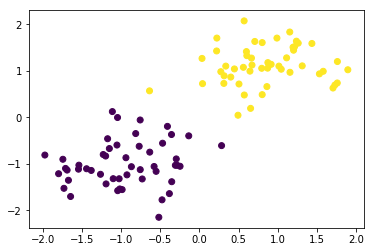

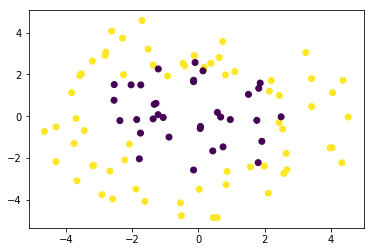

In [3]:
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

d,t = categorical1(100)
plt.figure(2)
plt.scatter(d[:,0],d[:,1], c=t)

d,t = categorical2(100)
plt.figure(3)
plt.scatter(d[:,0],d[:,1], c=t)

In [4]:
def decision_b(X = None, Y1 = None ):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # grid stepsize
    h = 0.025

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z2 = np.copy(Z)

    Z[Z>.5] = 1
    Z[Z<= .5] = 0

    Y_pr = model.predict(X, batch_size = X.shape[0], verbose=0).reshape(Y1.shape)
  
    Y = np.copy(Y1)
    Y_pr[Y_pr>.5] = 1
    Y_pr[Y_pr<= .5] = 0
    Y[(Y!=Y_pr) & (Y==0)] = 2
    Y[(Y!=Y_pr) & (Y==1)] = 3
    
    
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha = .5) 
    #plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    
    
    plt.scatter(X[:, 0][Y==1], X[:, 1][Y==1], marker='+', c='green')
    plt.scatter(X[:, 0][Y==0], X[:, 1][Y==0], marker='o', c='green')
       
    plt.scatter(X[:, 0][Y==3], X[:, 1][Y==3], marker = '+', c='r')   
    plt.scatter(X[:, 0][Y==2], X[:, 1][Y==2], marker = 'o', c='r')
    
    
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.tight_layout()

    return 

### Model creation 
#### Linearly seperable data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Train on 450 samples, validate on 50 samples
Epoch 1/20
450/450 [==============================] - 0s 574us/step - loss: 1.3643 - acc: 0.0000e+00 - val_loss: 1.2863 - val_acc: 0.0000e+00
Epoch 2/20
450/450 [==============================] - 0s 109us/step - loss: 1.1948 - acc: 0.0000e+00 - val_loss: 1.1338 - val_acc: 0.0000e+00
Epoch 3/20
450/450 [==============================] - 0s 103us/step - loss: 1.0469 - acc: 0.0000e+00 - val_loss: 1.0012 - val_acc: 0.0000e+00
Epoch 4/20
450/450 [==============================] - 0s 86us/step - loss: 0.9199 - acc: 0.0000e+00 - val_loss: 0.8871 - val_acc: 0.0000e+00
Epoch 5/20
450/450 [==============================] - 0s 93us/st

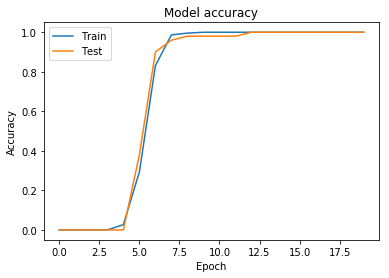

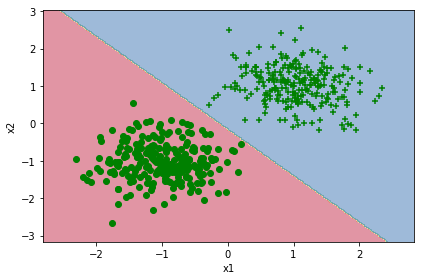

In [5]:
# Training data, and target
input_train, target_train = categorical1(500)

# Initialize a Sequential model, which is basically a linear, feed forward NN
from keras import Sequential
model = Sequential()

# Add 1 layer, input defined, and 1 output node (units), and activation function. The Dense function does
# the operation activation(Input*weights + bias).
model.add(Dense(units=1,               # number of output nodes of this layer
                input_dim = 2,         # dimension of the input (only need to specify for first layer)
                activation='sigmoid')) # activation function

# Define the updating algorithm
model.compile(loss='binary_crossentropy', # loss function
              optimizer='sgd',            # updating method
              metrics=['accuracy'])       # metrics

# Get a summary of the model. 
model.summary()

# Fit the model to the data and save the training history
history = model.fit(input_train,           # Input training data
                    target_train,          # Target data for this input
                    epochs=20,             # Number of epochs
                    batch_size=30,         # batch size to train each epoch
                    validation_split=0.1)  # split to get idea of generalization

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

decision_b(input_train, target_train)

## Model creation
### Non-linearly seperable data -> Hidden layer needed

In this instance, three hidden nodes are the minimal requirement to enclose a surface. Overtraining can be very clearly shown by increasing the number of hidden nodes up to 40. Here you can see that the decision boundary on the training data makes erratic moves just to capture outlying data points. However, this does not transfer well to validation data.
Ways to reduce overtrainig: 1. decrease number of hidden nodes, 2. decrease learning rate, 3. introduce regularizers


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 7)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


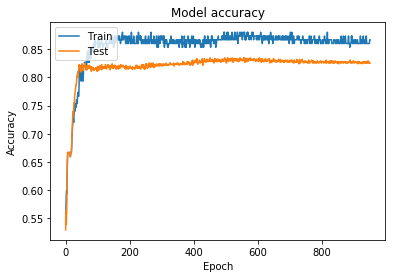

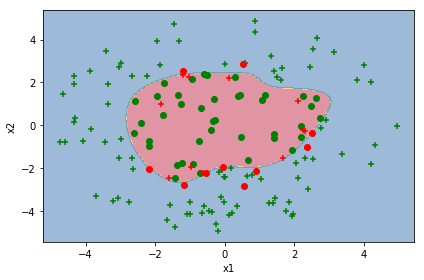

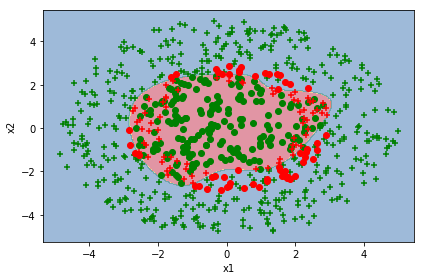

In [6]:
# Training data, and target
input_train, target_train = categorical2(150)
input_val, target_val = categorical2(750)

# Initialize a Sequential model, which is basically a linear, feed forward NN
from keras import Sequential
model = Sequential()

# Add 1 layer, input defined, and 1 output node (units), and activation function. The Dense function does
# the operation activation(Input*weights + bias).
# This is input + hidden layer
model.add(Dense(units=7,               # number of output nodes of this layer (need minimum of three for this problem)
                input_dim = 2,         # dimension of the input (only need to specify for first layer)
                activation='tanh'))     # activation function.
                #kernel_regularizer=regularizers.l2(0.01)))   # Network can be regularized l2. 


# Output layer
model.add(Dense(units=1,                # Three hidden nodes
                activation='sigmoid'))  # Output layer must have sigmoid.


# Define the updating algorithm
model.compile(loss='binary_crossentropy',            # loss function
              optimizer=optimizers.adam(lr=0.01),    # updating method, with lr
              metrics=['accuracy'])                  # metrics

# Get a summary of the model. 
model.summary()

# Fit the model to the data and save the training history
history = model.fit(input_train,           # Input training data
                    target_train,          # Target data for this input
                    epochs=950,             # Number of epochs
                    batch_size=30,         # batch size to train each epoch
                    #validation_split=0.1,  # split to get idea of generalization
                    validation_data=(input_val, target_val), # manually set val data
                    verbose = 0)  # 1 to print all calc steps

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

decision_b(input_train, target_train)
decision_b(input_val, target_val)

## Regression models

N = 800, N1 = 1600
1-20-20-1 (tanh,tanh,linear, 4000 epochs, 500 bs, adam 0.005

The regularizerl2 set at 0.01 will cause problems when training for fast oscillating stuff such as sin*cos... for these, set param to 0. I GUESS IT WILL ONLY BE BENEFICIAL FOR FAST OSCILLATING TRAINING DATA SUCH AS NOISE

-----So if noise is added, without the l2 regularizer the fit looks a bit trying to catch outliers. If l2 is put on, this dissapears. When no noise is present, the regularizer can become a serious problem for regularly (signal) fast oscillating functions.

For example: The sin*cos with noise performs much better with L2 regu. with parameter 0.00001. However, if the parameter becomes any bigger, it will perform worse than without.
If there is no noise, l2 regularization is NOT needed, and will in fact worsen the performance.
--> So when it is needed (with noise) then use only with small parameters and increase.
--> Zero noise with l2 = 0.00001 gives better result than l2=0 (sometimes).


So sin*cos wihtout noise and l2=0 is good. Then introduce l2=0.00001 makes it worse. Then adding noise 0.2 makes it better again.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_294 (Dense)            (None, 20)                40        
_________________________________________________________________
dense_295 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_296 (Dense)            (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


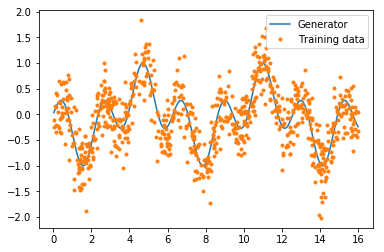

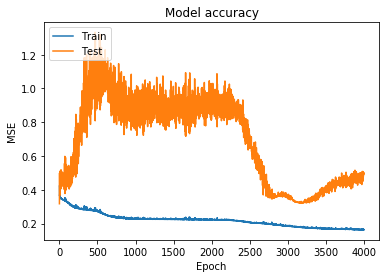

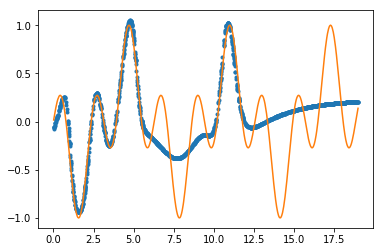

In [136]:
# generating data
N = 800
x_train = np.random.uniform(0,16,N) # random x_data
x_train.sort()                      # sort only for plot purposes
generator = np.sin(x_train)*np.cos(2*x_train)       # Underlying function
noise = np.random.normal(loc=0.0, scale=0.5, size=N) # gaussian noise
data_train = generator + 0.7 * noise      # Training data is noise added on to generator
                                         # ADDING LITTLE NOISE TO DATA IMPROVES MODEL ROBUSTNESS

# plot
plt.figure()
plt.plot(x_train, generator, label='Generator')
plt.plot(x_train, data_train,'.', label='Training data')
plt.legend()

# Question: Can we build ANN that can predict y for random x in range 0,10
# Follow-up: Can it predict y for random x outside range 0,10 (time-series questions)--> NO

# Building the model
model = Sequential() #initiate a sequential

# Input + hidden layer
model.add(Dense(units=20,              # number of output nodes of this layer (need minimum of three for this problem)
                input_dim = 1,         # dimension of the input (only need to specify for first layer)
                activation='tanh',     # tanh for regression (non-bound)
                kernel_regularizer=regularizers.l2(0.00005)))    

#Another hidden layer
model.add(Dense(units=20,               # number of output nodes of this layer (need minimum of three for this problem)
                activation='tanh',
                kernel_regularizer=regularizers.l2(0.00005)))    # tanh for regression (non-bound)

# Output layer
model.add(Dense(units=1,                # Three hidden nodes
                activation='linear'))  # Output layer must have sigmoid.

# Define the updating algorithm
model.compile(loss='mean_squared_error',            # loss function for regression
              optimizer=optimizers.adam(lr=0.005),    # updating method, with lr
              metrics=['accuracy'])                  # metrics

# Get a summary of the model. 
model.summary()


# Fit the model to the data and save the training history
history = model.fit(x_train,           # Input training data
                    data_train,          # Target data for this input
                    epochs=4000,             # Number of epochs
                    batch_size=500,         # batch size to train each epoch
                    validation_split=0.2,  # split to get idea of generalization
                    #validation_data=(input_val, target_val), # manually set val data
                    verbose = 0)  # 1 to print all calc steps

# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Generate testing data
N1 = 1600;
x_test = np.random.uniform(0,19,N1)
x_test.sort()

y_pred = model.predict(x_test)

plt.figure()
plt.plot(x_test, y_pred, '.')
plt.plot(x_test, np.sin(x_test)*np.cos(2*x_test))

mse = ((y_pred - np.sin(x_test)*np.cos(2*x_test))**2).mean()



In [133]:
mse

0.6279652474410529

Previous example with noise and l2 shows that one model can be trained to different, diverging performances. Thus, we need ensemble machines
